In [1]:
"""
Second Random Forest model with more features and balance the classes by oversampling

"""

'\nSecond Random Forest model with more features and balance the classes by oversampling\n\n'

In [2]:
import pandas as pd
import numpy as np
import datetime
import pickle

In [3]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, f1_score, fbeta_score 

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
from imblearn.over_sampling import RandomOverSampler, SMOTE
from collections import Counter

In [6]:
from sklearn.metrics import plot_roc_curve, plot_precision_recall_curve

In [7]:
# the df with features and target

with open('train_val_data.pickle', 'rb') as read_file:
    model_data = pickle.load(read_file)
    
model_data.head()

,company_name,period_end_date,number_of_quarters,submission_number,central_index_key,ein,sic,fiscal_year_end,fiscal_year,form,...,FY_end_day,keep_row,Industry,div_code,Division,FULL_NAME,bankruptcy_date,time_delta,days,target
0,1 800 FLOWERS COM INC,2014-06-30,0,0001437749-17-015969,1084869,113117311,5990,630,2017,10-K,...,30,1,"Retail-Retail Stores, NEC",59,Retail Trade,NaN,NaT,NaT,NaN,0
1,1 800 FLOWERS COM INC,2015-06-30,0,0001437749-18-017027,1084869,113117311,5990,630,2018,10-K,...,30,1,"Retail-Retail Stores, NEC",59,Retail Trade,NaN,NaT,NaT,NaN,0
2,1 800 FLOWERS COM INC,2016-06-30,0,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,30,1,"Retail-Retail Stores, NEC",59,Retail Trade,NaN,NaT,NaT,NaN,0
3,1 800 FLOWERS COM INC,2017-06-30,4,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,30,1,"Retail-Retail Stores, NEC",59,Retail Trade,NaN,NaT,NaT,NaN,0
4,1 800 FLOWERS COM INC,2018-06-30,4,0001437749-19-018360,1084869,113117311,5990,630,2019,10-K,...,30,1,"Retail-Retail Stores, NEC",59,Retail Trade,NaN,NaT,NaT,NaN,0


In [11]:
# filter to columns that are most complete

model_data_subset = model_data[['company_name', 'period_end_date', 'bankruptcy_date', 'days',
                                'Assets', 'Liabilities', 'StockholdersEquity', 'NetIncomeLoss',
                         'OperatingIncomeLoss', 'EarningsPerShareDiluted', 'Division', 'target' ]]

In [12]:
## RF will not accept NaNs

## change all NaN to zero

model_ready = model_data_subset.fillna(0)
model_ready.head(2)

,company_name,period_end_date,bankruptcy_date,days,Assets,Liabilities,StockholdersEquity,NetIncomeLoss,OperatingIncomeLoss,EarningsPerShareDiluted,Division,target
0,1 800 FLOWERS COM INC,2014-06-30,0,0.0,267569000.0,81451000.0,183228000.0,0.0,23706000.0,0.23,Retail Trade,0
1,1 800 FLOWERS COM INC,2015-06-30,0,0.0,497073000.0,286817000.0,208449000.0,0.0,37617000.0,0.30,Retail Trade,0


In [13]:
model_ready.shape

(19897, 12)

In [14]:
model_ready.company_name.nunique()

5373

In [15]:
# RFM will not process with large numbers
# put large dollar amounts in millions
model_ready['Assets_MM'] = model_ready['Assets'] / 1e6
#model_ready['AssetsCurrent_MM'] = model_ready['AssetsCurrent'] / 1e6
model_ready['Libilities_MM'] = model_ready['Liabilities'] / 1e6
#model_ready['LibilitiesCurrent_MM'] = model_ready['LiabilitiesCurrent'] / 1e6
model_ready['NetIncomeLoss_MM'] = model_ready['NetIncomeLoss'] / 1e6
model_ready['StockholdersEquity_MM'] = model_ready['StockholdersEquity'] / 1e6
model_ready['OperatingIncomeLoss_MM'] = model_ready['OperatingIncomeLoss'] / 1e6
#model_ready['Revenues_MM'] = model_ready['Revenues'] / 1e6


In [16]:
model_ready.columns

Index(['company_name', 'period_end_date', 'bankruptcy_date', 'days', 'Assets',
       'Liabilities', 'StockholdersEquity', 'NetIncomeLoss',
       'OperatingIncomeLoss', 'EarningsPerShareDiluted', 'Division', 'target',
       'Assets_MM', 'Libilities_MM', 'NetIncomeLoss_MM',
       'StockholdersEquity_MM', 'OperatingIncomeLoss_MM'],
      dtype='object')

In [17]:
model_ready.head()


,company_name,period_end_date,bankruptcy_date,days,Assets,Liabilities,StockholdersEquity,NetIncomeLoss,OperatingIncomeLoss,EarningsPerShareDiluted,Division,target,Assets_MM,Libilities_MM,NetIncomeLoss_MM,StockholdersEquity_MM,OperatingIncomeLoss_MM
0,1 800 FLOWERS COM INC,2014-06-30,0,0.0,267569000.0,81451000.0,183228000.0,0.0,23706000.0,0.23,Retail Trade,0,267.569,81.451,0.000,183.228,23.706
1,1 800 FLOWERS COM INC,2015-06-30,0,0.0,497073000.0,286817000.0,208449000.0,0.0,37617000.0,0.30,Retail Trade,0,497.073,286.817,0.000,208.449,37.617
2,1 800 FLOWERS COM INC,2016-06-30,0,0.0,502941000.0,260355000.0,242586000.0,0.0,43282000.0,0.55,Retail Trade,0,502.941,260.355,0.000,242.586,43.282
3,1 800 FLOWERS COM INC,2017-06-30,0,0.0,552470000.0,270231000.0,282239000.0,44041000.0,46359000.0,0.65,Retail Trade,0,552.470,270.231,44.041,282.239,46.359
4,1 800 FLOWERS COM INC,2018-06-30,0,0.0,570889000.0,255985000.0,314904000.0,40791000.0,41048000.0,0.61,Retail Trade,0,570.889,255.985,40.791,314.904,41.048


In [18]:
# one hot encoding for the industry division

div_code = model_ready[['Division']]

one = OneHotEncoder(sparse=False)
one.fit(div_code)
cats = one.transform(div_code)

columns = one.get_feature_names(['Division'])
div_code_df = pd.DataFrame(cats, columns=columns, index=div_code.index)

div_code_df

,"Division_Agriculture, Forestry and Fishing",Division_Construction,"Division_Finance, Insurance and Real Estate",Division_Manufacturing,Division_Mining,Division_Retail Trade,Division_Services,"Division_Transportation, Communications, Electric, Gas and Sanitary service",Division_Wholesale Trade
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
19892,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19893,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19894,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
19895,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
rfm_ready = pd.concat([model_ready, div_code_df], axis=1)
rfm_ready.head()

,company_name,period_end_date,bankruptcy_date,days,Assets,Liabilities,StockholdersEquity,NetIncomeLoss,OperatingIncomeLoss,EarningsPerShareDiluted,...,OperatingIncomeLoss_MM,"Division_Agriculture, Forestry and Fishing",Division_Construction,"Division_Finance, Insurance and Real Estate",Division_Manufacturing,Division_Mining,Division_Retail Trade,Division_Services,"Division_Transportation, Communications, Electric, Gas and Sanitary service",Division_Wholesale Trade
0,1 800 FLOWERS COM INC,2014-06-30,0,0.0,267569000.0,81451000.0,183228000.0,0.0,23706000.0,0.23,...,23.706,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,1 800 FLOWERS COM INC,2015-06-30,0,0.0,497073000.0,286817000.0,208449000.0,0.0,37617000.0,0.30,...,37.617,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1 800 FLOWERS COM INC,2016-06-30,0,0.0,502941000.0,260355000.0,242586000.0,0.0,43282000.0,0.55,...,43.282,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,1 800 FLOWERS COM INC,2017-06-30,0,0.0,552470000.0,270231000.0,282239000.0,44041000.0,46359000.0,0.65,...,46.359,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,1 800 FLOWERS COM INC,2018-06-30,0,0.0,570889000.0,255985000.0,314904000.0,40791000.0,41048000.0,0.61,...,41.048,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [20]:
rfm_ready.shape

(19897, 26)

In [21]:
rfm_ready.columns

Index(['company_name', 'period_end_date', 'bankruptcy_date', 'days', 'Assets',
       'Liabilities', 'StockholdersEquity', 'NetIncomeLoss',
       'OperatingIncomeLoss', 'EarningsPerShareDiluted', 'Division', 'target',
       'Assets_MM', 'Libilities_MM', 'NetIncomeLoss_MM',
       'StockholdersEquity_MM', 'OperatingIncomeLoss_MM',
       'Division_Agriculture, Forestry and Fishing', 'Division_Construction',
       'Division_Finance, Insurance and Real Estate', 'Division_Manufacturing',
       'Division_Mining', 'Division_Retail Trade', 'Division_Services',
       'Division_Transportation, Communications, Electric, Gas and Sanitary service',
       'Division_Wholesale Trade'],
      dtype='object')

In [23]:
X = rfm_ready[['Assets_MM', 'Libilities_MM',  
                 'StockholdersEquity_MM', 'OperatingIncomeLoss_MM', 'NetIncomeLoss_MM',
                  'EarningsPerShareDiluted',
                  'Division_Agriculture, Forestry and Fishing', 
                 'Division_Construction', 'Division_Finance, Insurance and Real Estate', 
                 'Division_Manufacturing', 'Division_Mining', 'Division_Retail Trade', 
                 'Division_Services', 'Division_Wholesale Trade',
                 'Division_Transportation, Communications, Electric, Gas and Sanitary service']]

y = rfm_ready['target']

In [24]:
# arrays for KFold
X, y = np.array(X), np.array(y)

kf = KFold(n_splits=5, shuffle=True, random_state = 47)
cv_rfm_recall = [] #collect the recall scores
#cv_rfm_matrix = []

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #balance the training set classes
    ros = RandomOverSampler(random_state=0)
    X_resampled, y_resampled = ros.fit_sample(X_train, y_train)

    
    #Random Forest
    randomforest = RandomForestClassifier(n_estimators=100)

    randomforest.fit(X_resampled, y_resampled)
      
    y_pred = randomforest.predict(X_val)
    
    cv_rfm_recall.append(round(recall_score(y_val, y_pred), 4))
      
    rf_confusion = confusion_matrix(y_val, y_pred)
    
    print('Matrix:' , rf_confusion)

print('RFM recall scores: ', cv_rfm_recall, '\n')

print(f'Mean CV recall: {np.mean(cv_rfm_recall):.3f} +- {np.std(cv_rfm_recall):.3f}', '\n')



Matrix: [[3956    6]
 [  16    2]]
Matrix: [[3954    2]
 [  24    0]]
Matrix: [[3955    4]
 [  20    0]]
Matrix: [[3960    6]
 [  13    0]]
Matrix: [[3951    3]
 [  24    1]]
RFM recall scores:  [0.1111, 0.0, 0.0, 0.0, 0.04] 

Mean CV recall: 0.030 +- 0.043 



In [ ]:
## try SMOTE oversampling


In [25]:
# arrays for KFold
X, y = np.array(X), np.array(y)

kf = KFold(n_splits=5, shuffle=True, random_state = 47)
cv_rfm_recall = [] #collect the recall scores
#cv_rfm_matrix = []

for train_ind, val_ind in kf.split(X, y):
    
    X_train, y_train = X[train_ind], y[train_ind]
    X_val, y_val = X[val_ind], y[val_ind] 
    
    #balance the training set classes
    X_smoted, y_smoted = SMOTE(random_state=42).fit_sample(X_train, y_train)

    #Random Forest
    randomforest = RandomForestClassifier(n_estimators=100)

    randomforest.fit(X_smoted, y_smoted)
      
    y_pred = randomforest.predict(X_val)
    
    cv_rfm_recall.append(round(recall_score(y_val, y_pred), 4))
      
    rf_confusion = confusion_matrix(y_val, y_pred)
    
    print('Matrix:' , rf_confusion)

print('RFM recall scores: ', cv_rfm_recall, '\n')

print(f'Mean CV recall: {np.mean(cv_rfm_recall):.3f} +- {np.std(cv_rfm_recall):.3f}', '\n')





Matrix: [[3940   22]
 [  14    4]]
Matrix: [[3937   19]
 [  18    6]]
Matrix: [[3943   16]
 [  13    7]]
Matrix: [[3950   16]
 [  11    2]]
Matrix: [[3927   27]
 [  19    6]]
RFM recall scores:  [0.2222, 0.25, 0.35, 0.1538, 0.24] 

Mean CV recall: 0.243 +- 0.063 



In [26]:
feature_names = ['Assets_MM', 'Libilities_MM',  
                 'StockholdersEquity_MM', 'OperatingIncomeLoss_MM', 'NetIncomeLoss_MM',
                  'EarningsPerShareDiluted',
                  'Division_Agriculture, Forestry and Fishing', 
                 'Division_Construction', 'Division_Finance, Insurance and Real Estate', 
                 'Division_Manufacturing', 'Division_Mining', 'Division_Retail Trade', 
                 'Division_Services', 'Division_Wholesale Trade',
                 'Division_Transportation, Communications, Electric, Gas and Sanitary service']

<BarContainer object of 15 artists>

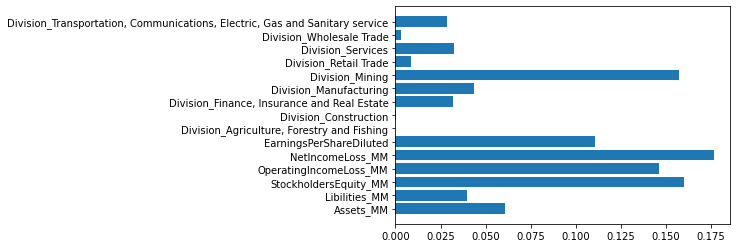

In [27]:
## last k-fold
plt.barh(feature_names, randomforest.feature_importances_)

In [ ]:
#Precision-Recall curves summarize the trade-off between the true positive rate and 
#the positive predictive value for a predictive model using different probability thresholds.

#Precision-Recall curves appropriate for imbalanced classes


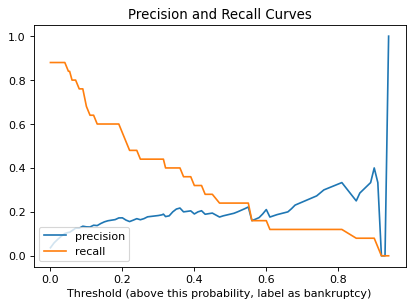

In [28]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_val, randomforest.predict_proba(X_val)[:,1] )

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:],label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as bankruptcy)');
plt.title('Precision and Recall Curves');

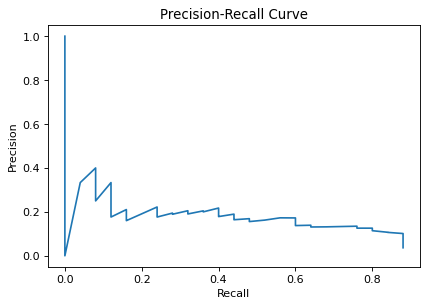

In [29]:
plt.figure(dpi=80)
plt.plot(recall_curve[1:], precision_curve[1:],label='precision')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve");

ROC AUC score =  0.9167627718765807


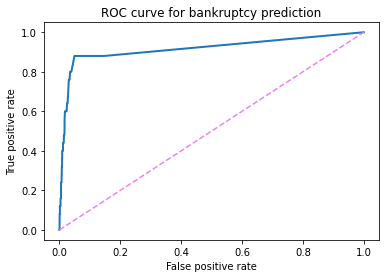

In [30]:
# ROC is appropriate for balanced classes, this is the code block

fpr, tpr, thresholds = roc_curve(y_val, randomforest.predict_proba(X_val)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve for bankruptcy prediction');
print("ROC AUC score = ", roc_auc_score(y_val, randomforest.predict_proba(X_val)[:,1]))

In [31]:
## confusion matrix
def make_confusion_matrix(model, threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_val)[:, 1] >= threshold)
    prob_confusion = confusion_matrix(y_val, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(prob_confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='d',
           xticklabels=['No', 'Yes'],
           yticklabels=['No', 'Yes']);
    plt.xlabel('Predicted Bankruptcy')
    plt.ylabel('Actual Bankruptcy')

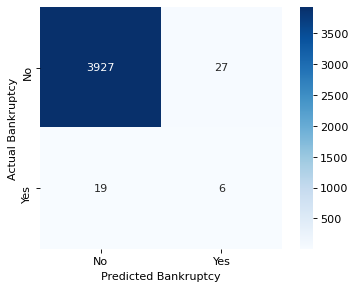

In [32]:
# last validation set in K-fold CV
make_confusion_matrix(randomforest)